# Case Study 3

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.

#### Requirements

  * compare at least 2 feature selection methods (groups of 5-6: at least 4)
    - filtering methods (at least one scoring function)
    - wrapper methods (at least one, e.g., forward feature selection or backward feature elimination)
    - embedding methods  (at least one, e.g., L1 regularisation)
 * combine each method with at least 2 classifiers 
   (justify your choice of classifiers in the report)
    - SVM
    - KNN
    - ...
  * perform Leave-one-group-out cross-validation, where all 10 samples from each subject are in one group (18 groups in total)
  * use cross-validation to optimise hyper-parameter values
  * as a baseline for comparison, evaluate each of your classifiers trained on the full set of features (trained without feature selection)




In [1]:
import csv
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

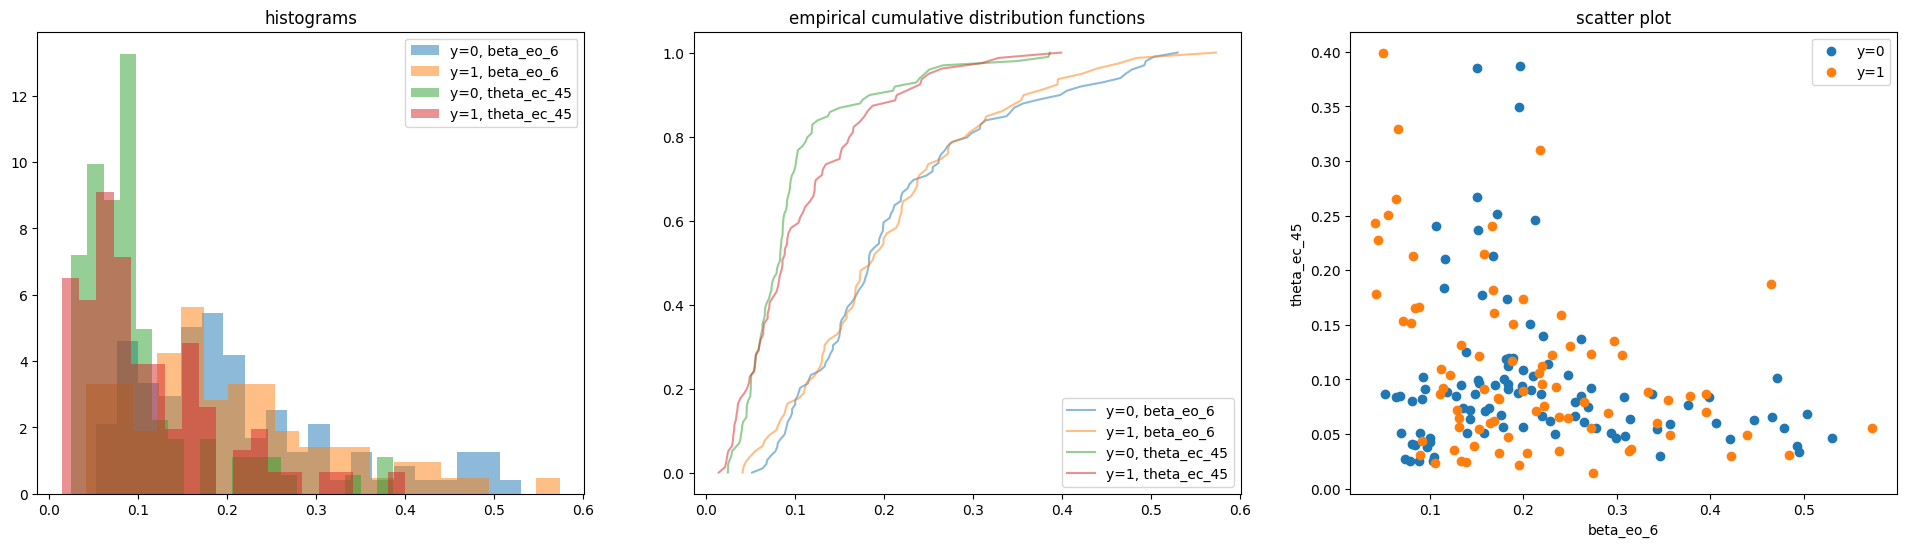

In [3]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)#432col里面随机选2个序列号

# b) same electrode, different feature (uncomment lines below)
#f0, f1 = np.random.randint(0, num_features, size=2)
#e = np.random.randint(0, num_electrodes)
#i0, i1 = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
#f = np.random.randint(0, num_features)
#e0, e1 = np.random.randint(0, num_electrodes, size=2)
#i0, i1 = f*num_electrodes + e0, f*num_electrodes + e1

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
colors = ['blue', 'red']

# select features i0, i1 and separate by class
X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
# plot cumulative distribution of feature i0 separate for each class
axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
axes[0].set_title('histograms')
axes[0].legend()
axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
axes[1].set_title('empirical cumulative distribution functions')
axes[1].legend()
axes[2].scatter(X00, X10, label='y=0')
axes[2].scatter(X01, X11, label='y=1')
axes[2].set_xlabel(feature_names[i0])
axes[2].set_ylabel(feature_names[i1])
axes[2].set_title('scatter plot')
axes[2].legend()

# Filtering Methods: Pearson Correlation Coefficient

In [4]:
import pandas as pd

dataset_all = np.column_stack((X, y))
columns = [name for name in feature_names]
columns.append('label')

df_dataset = pd.DataFrame(data=dataset_all, columns=columns)
p1=df_dataset.corr(method='pearson')

n1=0
X1=[]
feature_names1=[]

for i in range(0,432):
    if p1.label[i] >=0.2 or p1.label[i]<=-0.2: #choose 0.2 as the thredshould
        for j in range(0,180):
            X1.append(X[j][i])
        n1=n1+1 #number of features
X1=np.array(X1)
X1=X1.reshape([180,n1])

In [5]:
n1

111

# Filtering Methods: Spearman's Rank Correlation Coefficient

In [6]:
p2=df_dataset.corr(method='spearman')
n2=0
X2=[]

for i in range(0,432):
    if p2.label[i] >=0.2 or p2.label[i]<=-0.2: #choose 0.2 as the thredshould
        for j in range(0,180):
            X2.append(X[j][i])
        n2=n2+1 #number of features
X2=np.array(X2)
X2=X2.reshape([180,n2])

In [7]:
n2

109

# Embedding Methods: L1 Regularization

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
 
X3 = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear')).fit_transform(X,  y)

In [9]:
#number of features
np.size(X3[0])

43

# Wrapper Methods:RFECV

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [11]:
#with LogisticRegression
selector = RFECV(LogisticRegression(solver='liblinear'), step=1)       # 采用交叉验证，每次排除一个特征，筛选出最优特征
selector = selector.fit(X,y)
X4=selector.transform(X)

In [12]:
# n_features_to_select:number of features
np.size(X4[0])

24

# Leave-one-out Cross-Validation

In [13]:
groups=[]
for i in range(0,18):
    for j in range(0,10):
            groups.append(i)

In [14]:
# select data from different feature selection
# X: origional data
# X1: Pearson Correlation Coefficient
# X2: Spearman's Rank Correlation Coefficient
# X2: L1 Regularization
# X3:RFE

X0=X4

In [15]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()
logo.get_n_splits(X0, y, groups)

18

# 2 Classifiers KNN&SVM

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [17]:
tp_knn=np.zeros(18)
fp_knn=np.zeros(18)
tn_knn=np.zeros(18)
fn_knn=np.zeros(18)
tp_svm=np.zeros(18)
fp_svm=np.zeros(18)
tn_svm=np.zeros(18)
fn_svm=np.zeros(18)
sensitivity_knn=np.zeros(18)
sensitivity_svm=np.zeros(18)
specificity_knn=np.zeros(18)
specificity_svm=np.zeros(18)
accuracy_knn=np.zeros(18)
accuracy_svm=np.zeros(18)
j=0


for train_index,test_index in logo.split(X0, y,groups):
    X_train,X_test=X0[train_index],X0[test_index]
    y_train,y_test=y[train_index],y[test_index]

    knn_model = KNeighborsClassifier(n_neighbors=2)
    knn_model.fit(X_train,y_train)
    knn_assignment = knn_model.predict(X_test)
    
    svm_model=svm.SVC(kernel = 'linear')
    svm_model.fit(X_train,y_train)
    svm_assignment = svm_model.predict(X_test)
    
    for i in range(0,10):
        if y_test[i]==1 and knn_assignment[i]==1:
            tp_knn[j]=tp_knn[j]+1
        if y_test[i]==1 and knn_assignment[i]==0:
            fn_knn[j]=fn_knn[j]+1
        if y_test[i]==0 and knn_assignment[i]==1:
            fp_knn[j]=fp_knn[j]+1
        if y_test[i]==0 and knn_assignment[i]==0:
            tn_knn[j]=tn_knn[j]+1
            
        if y_test[i]==1 and svm_assignment[i]==1:
            tp_svm[j]=tp_svm[j]+1
        if y_test[i]==1 and svm_assignment[i]==0:
            fn_svm[j]=fn_svm[j]+1
        if y_test[i]==0 and svm_assignment[i]==1:
            fp_svm[j]=fp_svm[j]+1
        if y_test[i]==0 and svm_assignment[i]==0:
            tn_svm[j]=tn_svm[j]+1
    j=j+1

sensitivity_knn=tp_knn/(tp_knn+fn_knn)
specificity_knn=tn_knn/(tn_knn+fp_knn)
accuracy_knn=(tp_knn+tn_knn)/(tp_knn+tn_knn+fp_knn+fn_knn)

sensitivity_svm=tp_svm/(tp_svm+fn_svm)
specificity_svm=tn_svm/(tn_svm+fp_svm)
accuracy_svm=(tp_svm+tn_svm)/(tp_svm+tn_svm+fp_svm+fn_svm)

C:\Users\10603\AppData\Local\Temp\ipykernel_18088\3975247405.py:50: RuntimeWarning: invalid value encountered in divide
  sensitivity_knn=tp_knn/(tp_knn+fn_knn)
C:\Users\10603\AppData\Local\Temp\ipykernel_18088\3975247405.py:51: RuntimeWarning: invalid value encountered in divide
  specificity_knn=tn_knn/(tn_knn+fp_knn)
C:\Users\10603\AppData\Local\Temp\ipykernel_18088\3975247405.py:54: RuntimeWarning: invalid value encountered in divide
  sensitivity_svm=tp_svm/(tp_svm+fn_svm)
C:\Users\10603\AppData\Local\Temp\ipykernel_18088\3975247405.py:55: RuntimeWarning: invalid value encountered in divide
  specificity_svm=tn_svm/(tn_svm+fp_svm)


In [18]:
sensitivity_knn = sensitivity_knn[~pd.isnull(sensitivity_knn)]
specificity_knn = specificity_knn[~pd.isnull(specificity_knn)]
accuracy_knn = accuracy_knn[~pd.isnull(accuracy_knn)]
sensitivity_svm = sensitivity_svm[~pd.isnull(sensitivity_svm)]
specificity_svm = specificity_svm[~pd.isnull(specificity_svm)]
accuracy_svm = accuracy_svm[~pd.isnull(accuracy_svm)]

sensitivity_knn_mean=np.mean(sensitivity_knn)
specificity_knn_mean=np.mean(specificity_knn)
accuracy_knn_mean=np.mean(accuracy_knn)
sensitivity_svm_mean=np.mean(sensitivity_svm)
specificity_svm_mean=np.mean(specificity_svm)
accuracy_svm_mean=np.mean(accuracy_svm)

sensitivity_knn_std=np.std(sensitivity_knn)
specificity_knn_std=np.std(specificity_knn)
accuracy_knn_std=np.std(accuracy_knn)
sensitivity_svm_std=np.std(sensitivity_svm)
specificity_svm_std=np.std(specificity_svm)
accuracy_svm_std=np.std(accuracy_svm)

In [19]:
print('Means')
pd.DataFrame({'Metrics': ['accuracy','sensitivity', 'specificity'], 'knn': [accuracy_knn_mean, sensitivity_knn_mean,specificity_knn_mean], 'svm':[accuracy_svm_mean, sensitivity_svm_mean,specificity_svm_mean]}).set_index('Metrics')

Means


,knn,svm
Metrics,,
accuracy,0.711111,0.872222
sensitivity,0.487500,0.862500
specificity,0.890000,0.880000


In [20]:
print('Standard deviations')
pd.DataFrame({'Metrics': ['accuracy','sensitivity', 'specificity'], 'knn': [accuracy_knn_std, sensitivity_knn_std,specificity_knn_std], 'svm':[accuracy_svm_std, sensitivity_svm_std,specificity_svm_std]}).set_index('Metrics')

Standard deviations


,knn,svm
Metrics,,
accuracy,0.237788,0.132521
sensitivity,0.161536,0.121835
specificity,0.094340,0.140000
